# How to Structure from Motion

## Authors: Muneeb Aadil, Sibt Ul Hussain

In [2]:
#loading needed libraries 
import utils as ut 
import SfM as sfmnp

import matplotlib.pyplot as plt 
%matplotlib notebook 
from mpl_toolkits.mplot3d import Axes3D

import cv2 
import numpy as np 

#auto-reloading external modules
%load_ext autoreload
%autoreload 2

# Chapter 1. Prerequisites

## 1.1. Transformations

## 1.2. Camera Models 

## 1.3 RANSAC

# Chapter 2. Epipolar Geometry

## 2.0. Reading a pair of images, and comparing SIFT matches

<IPython.core.display.Javascript object>


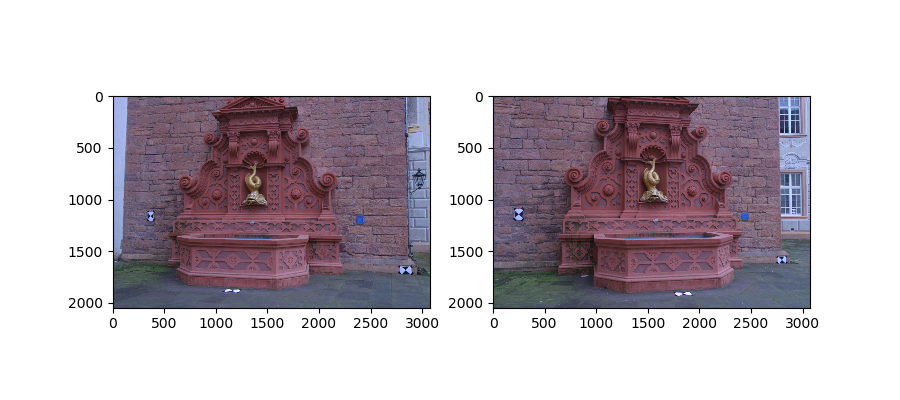

In [3]:
#Reading two images for reference
img1 = cv2.imread('../data/fountain-P11/images/0004.jpg')
img2 = cv2.imread('../data/fountain-P11/images/0006.jpg')

#Converting from BGR to RGB format
img1 = img1[:,:,::-1]
img2 = img2[:,:,::-1]

#NOTE: you can adjust appropriate figure size according to the size of your screen
fig,ax=plt.subplots(ncols=2,figsize=(9,4)) 
ax[0].imshow(img1)
ax[1].imshow(img2)

In [6]:
#Getting SIFT/SURF features for image matching (this might take a while)
kp1,desc1,kp2,desc2,matches=ut.GetImageMatches(img1,img2)

#Aligning two keypoint vectors
img1pts,img2pts,img1idx,img2idx=ut.GetAlignedMatches(kp1,desc1,kp2,desc2,matches)

## 2.2. Fundamental Matrix Computation

### 2.2.1. Eight Point Algorithm

In [7]:
img1pts_, img2pts_ = img1pts[:8], img2pts[:8]
Fgt, mask = cv2.findFundamentalMat(img1pts_,img2pts_,method=cv2.FM_8POINT)
F = sfmnp.EstimateFundamentalMatrix(img1pts_,img2pts_)

In [8]:
print F 
print 
print Fgt
np.testing.assert_allclose(F, Fgt, rtol=1e-7,atol=1e-3)

[[-4.14372595e-08  8.28715213e-08 -8.43625823e-05]
 [ 4.15072787e-07  2.95698948e-08  2.97788200e-03]
 [-3.31657099e-04 -3.91844172e-03  1.00000000e+00]]

[[-5.97892969e-09  7.76025698e-08 -1.20887915e-04]
 [ 3.84560269e-07  2.73818759e-08  2.75620056e-03]
 [-3.63233286e-04 -3.62885238e-03  1.00000000e+00]]


### 2.2.2. Normalized 8 Point Algorithm

In [9]:
F_normalized = sfmnp.EstimateFundamentalMatrixNormalized(img1pts_,img2pts_)

### 2.2.3. with RANSAC (Random Sample Consensus)

In [15]:
Fgt, maskgt = cv2.findFundamentalMat(img1pts,img2pts,method=cv2.FM_RANSAC,param1=.1)
maskgt = maskgt.astype(bool).flatten()

F, mask = sfmnp.EstimateFundamentalMatrixRANSAC(img1pts,img2pts,.1,iters=20000)

In [16]:
print Fgt 
print 
print F

np.testing.assert_allclose(F,Fgt,rtol=1e-7,atol=1e-3)

[[-7.81818018e-09  1.16620400e-07 -1.75262208e-04]
 [ 3.42813088e-07  1.64778335e-08  2.80101788e-03]
 [-3.02277699e-04 -3.65923057e-03  1.00000000e+00]]

[[-4.95799365e-09  1.47158703e-07 -1.92515796e-04]
 [ 3.07797901e-07  1.69734267e-08  2.80867975e-03]
 [-2.89429859e-04 -3.66557954e-03  1.00000000e+00]]


## 2.2. Epipolar Lines Computation

In [17]:
lines2=sfmnp.ComputeEpiline(img1pts[mask],1,F)
lines1=sfmnp.ComputeEpiline(img2pts[mask],2,F)

## 2.3. Epipoles Computation

In [10]:
#to do later..

## 2.4. Visualizations I: Epipolar Geometry
### 2.4.1. Epipolar Lines

<IPython.core.display.Javascript object>


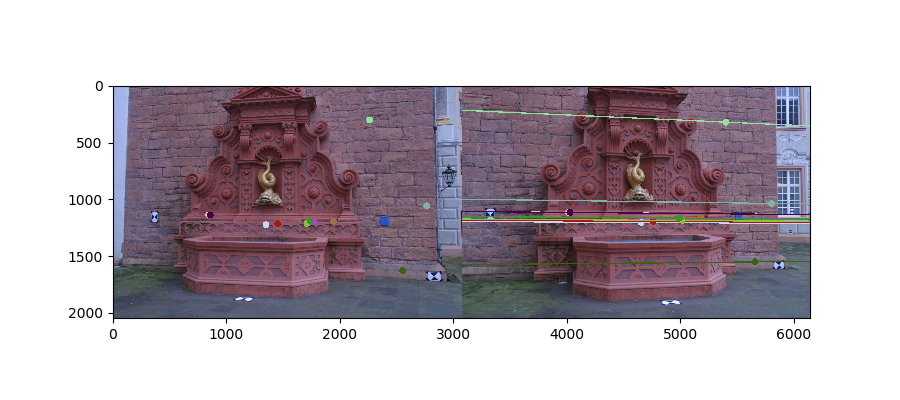

<IPython.core.display.Javascript object>


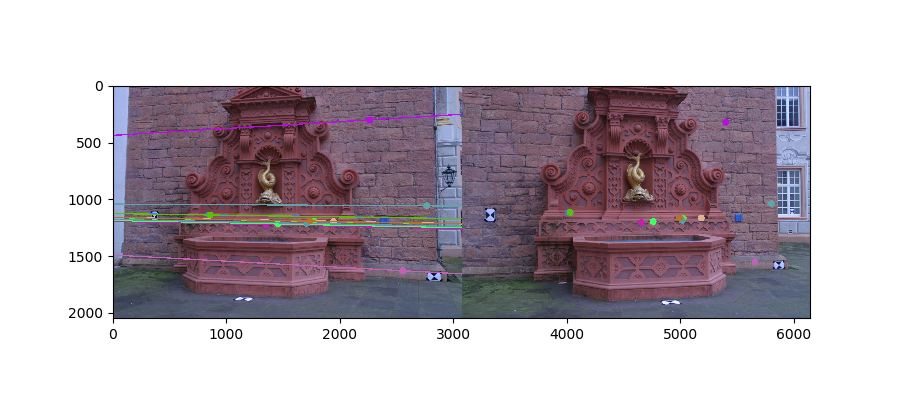

In [18]:
tup = ut.drawlines(img2,img1,lines2,img2pts[mask],img1pts[mask],drawOnly=10,
                   linesize=10,circlesize=30)
epilines2 = np.concatenate(tup[::-1],axis=1) #reversing the order of left and right images

plt.figure(figsize=(9,4))
plt.imshow(epilines2)

tup = ut.drawlines(img1,img2,lines1,img1pts[mask],img2pts[mask],drawOnly=10,
                   linesize=10,circlesize=30)
epilines1 = np.concatenate(tup,axis=1) 

plt.figure(figsize=(9,4))
plt.imshow(epilines1)

### 2.4.2. Epipoles

In [12]:
# to do later..

## 2.5. Pose Estimation

In [19]:
K = np.array([[2759.48,0,1520.69],[0,2764.16,1006.81],[0,0,1]])
E = K.T.dot(F.dot(K))

R1,R2,t = sfmnp.ExtractCameraPoses(E)
t = t[:,np.newaxis]

## 2.6. Visualizations II: Camera Poses

<IPython.core.display.Javascript object>


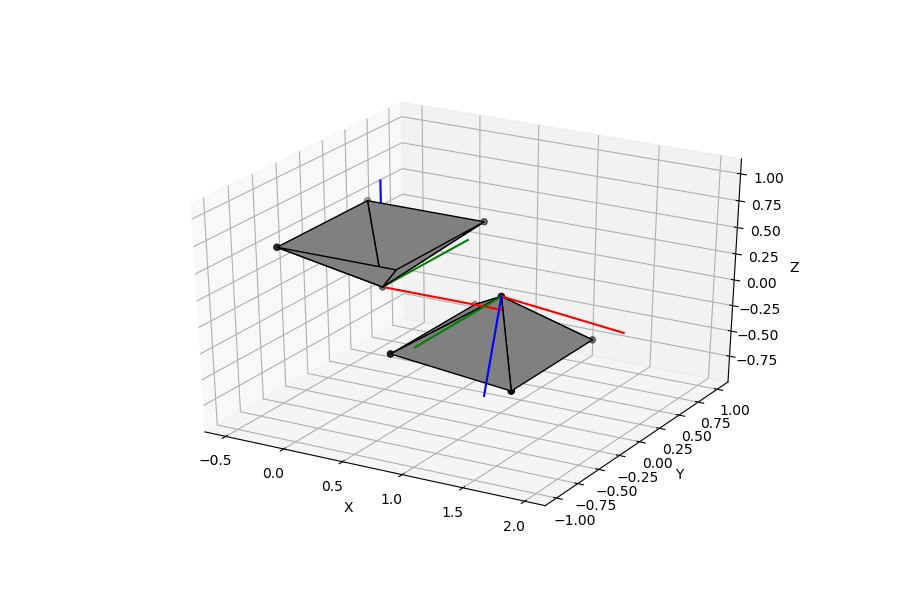

<IPython.core.display.Javascript object>


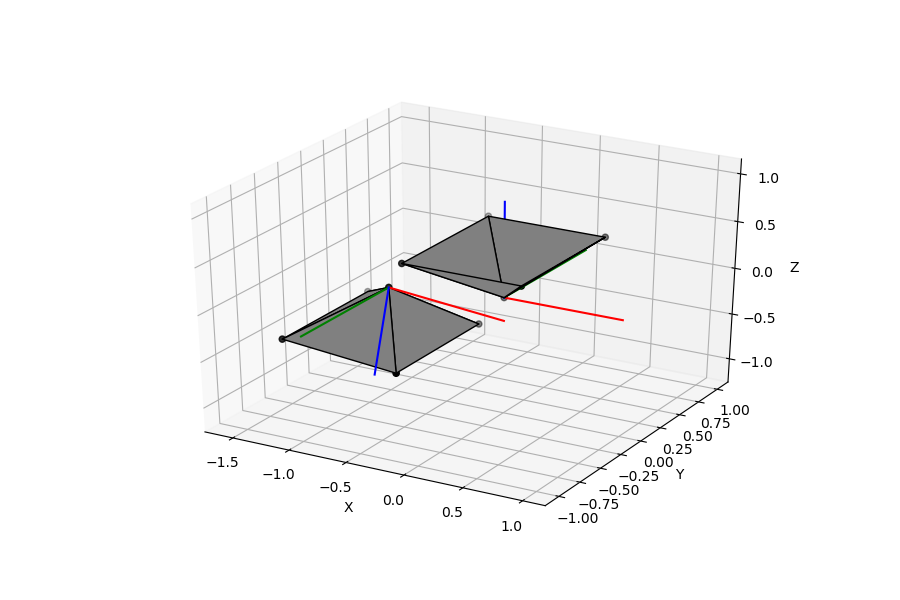

<IPython.core.display.Javascript object>


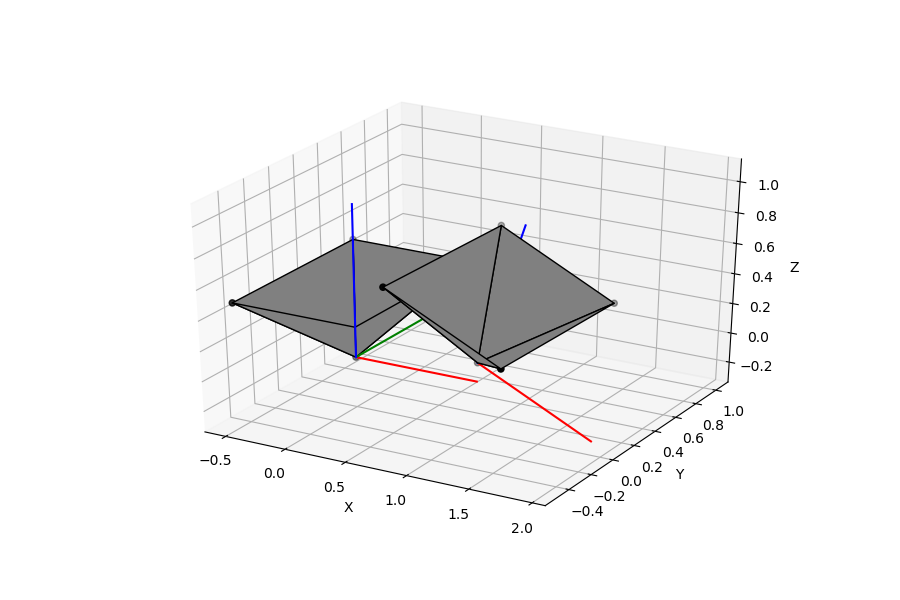

<IPython.core.display.Javascript object>


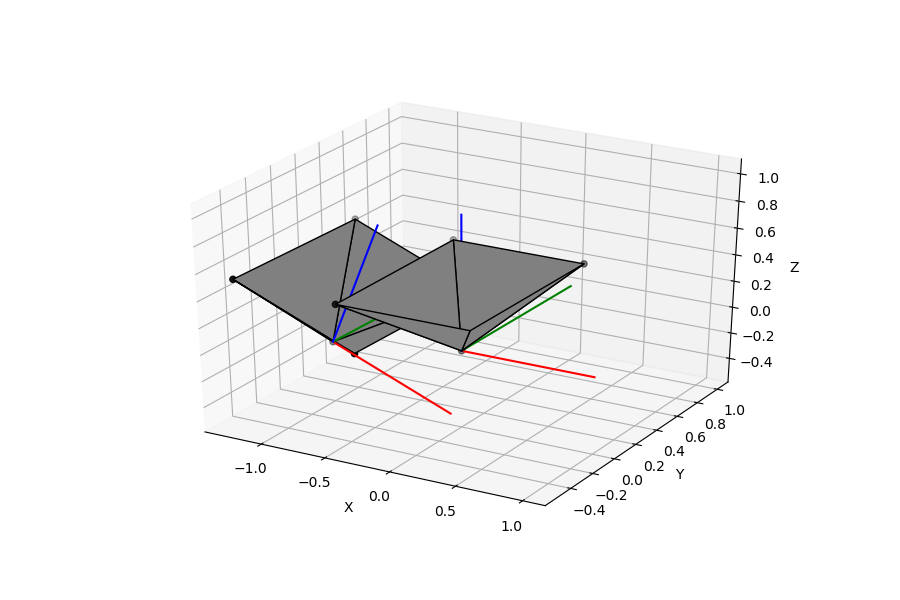

In [20]:
for R_ in [R1,R2]: 
    for t_ in [t,-t]:
        
        fig = plt.figure(figsize=(9,6))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

        ut.PlotCamera(np.eye(3,3),np.zeros((3,)),ax)
        ut.PlotCamera(R_,t_[:,0],ax)

# Chapter 3. 3D Scene Estimations

## 3.1. Triangulation: DLT Method 

In [21]:
def GetTriangulatedPts(img1pts,img2pts,K,R,t,triangulateFunc): 
    img1ptsHom = cv2.convertPointsToHomogeneous(img1pts)[:,0,:]
    img2ptsHom = cv2.convertPointsToHomogeneous(img2pts)[:,0,:]

    img1ptsNorm = (np.linalg.inv(K).dot(img1ptsHom.T)).T
    img2ptsNorm = (np.linalg.inv(K).dot(img2ptsHom.T)).T

    img1ptsNorm = cv2.convertPointsFromHomogeneous(img1ptsNorm)[:,0,:]
    img2ptsNorm = cv2.convertPointsFromHomogeneous(img2ptsNorm)[:,0,:]
    
    pts4d = triangulateFunc(np.eye(3,4),np.hstack((R,t)),img1ptsNorm.T,img2ptsNorm.T)
    pts3d = cv2.convertPointsFromHomogeneous(pts4d.T)[:,0,:]
    
    return pts3d

In [24]:
pts3dgt = GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R2,t,cv2.triangulatePoints)
pts3d = GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R2,t,sfmnp.Triangulate)

In [25]:
print pts3dgt[:5]
print 
print pts3d[:5]
np.testing.assert_allclose(pts3d,pts3dgt,rtol=1e-7,atol=1e-3)

[[-0.20538011 -0.15822107 -2.2744921 ]
 [ 0.14205583 -0.18082672 -2.24722573]
 [ 0.05715696 -0.17399485 -2.23255088]
 [-0.82466885 -0.50377816 -2.21187558]
 [ 0.60381689 -0.12101426 -2.46185569]]

[[-0.20538945 -0.15823158 -2.27452636]
 [ 0.14206111 -0.180824   -2.2472177 ]
 [ 0.05715933 -0.17399703 -2.23255718]
 [-0.82531486 -0.50402876 -2.21292638]
 [ 0.60381667 -0.12100653 -2.46181554]]


AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0.001

(mismatch 11.4058956916%)
 x: array([[-0.205389, -0.158232, -2.274526],
       [ 0.142061, -0.180824, -2.247218],
       [ 0.057159, -0.173997, -2.232557],...
 y: array([[-0.20538 , -0.158221, -2.274492],
       [ 0.142056, -0.180827, -2.247226],
       [ 0.057157, -0.173995, -2.232551],...

In [26]:
configSet = [None,None,None,None]
configSet[0] = (R1,t,GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R1,t,cv2.triangulatePoints))
configSet[1] = (R1,-t,GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R1,-t,cv2.triangulatePoints))
configSet[2] = (R2,t,GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R2,t,cv2.triangulatePoints))
configSet[3] = (R2,-t,GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R2,-t,cv2.triangulatePoints))

## 3.2. Visualizing the triangulated points of configurations

<IPython.core.display.Javascript object>


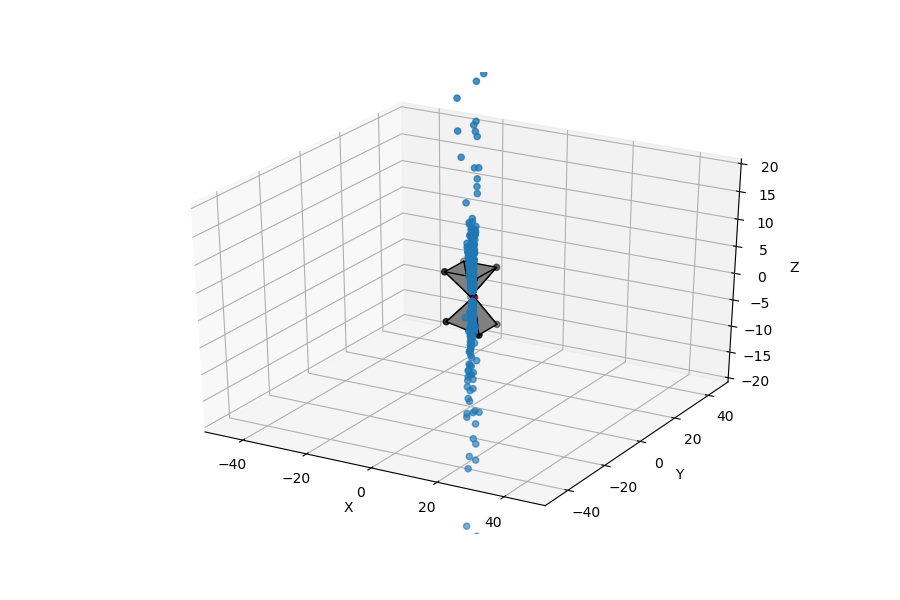

<IPython.core.display.Javascript object>


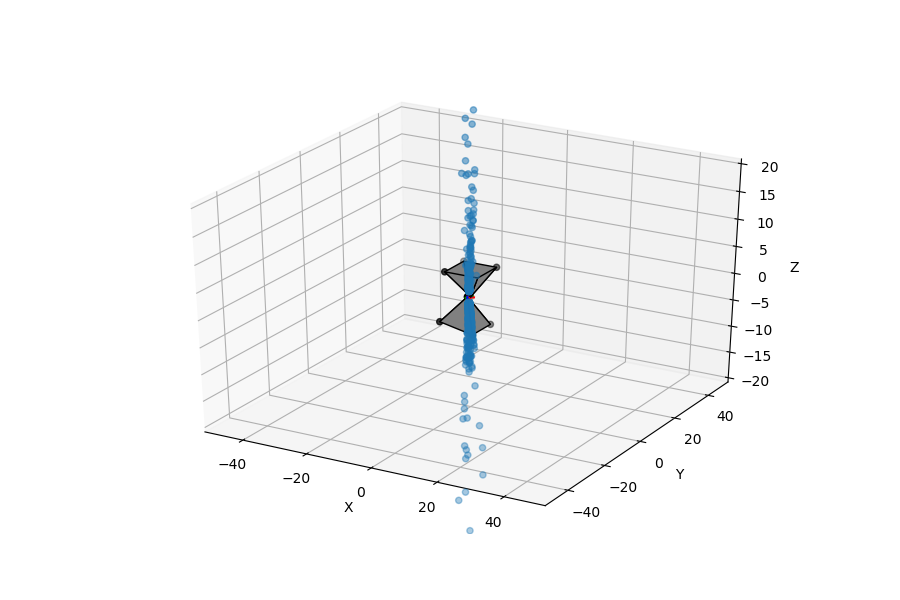

<IPython.core.display.Javascript object>


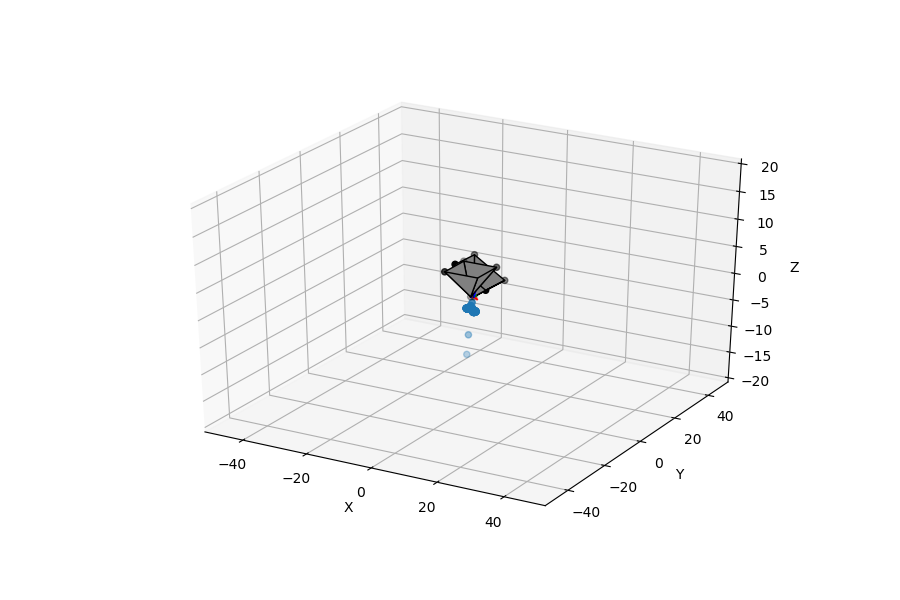

<IPython.core.display.Javascript object>


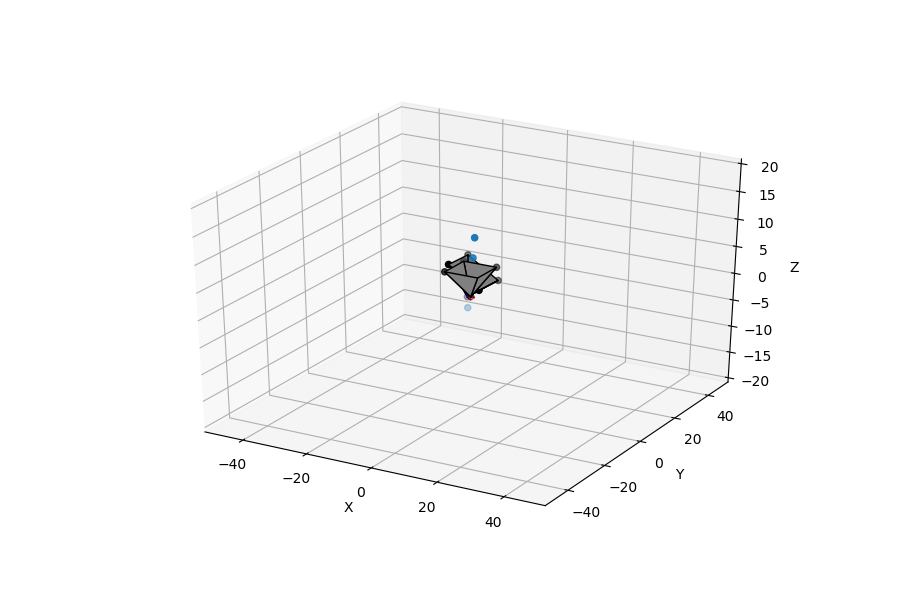

In [27]:
for cs in configSet: 
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ut.PlotCamera(np.eye(3,3),np.zeros((3,)),ax,scale=5,depth=5)
    ut.PlotCamera(cs[0],cs[1][:,0],ax,scale=5,depth=5)

    pts3d = cs[-1]
    ax.scatter3D(pts3d[:,0],pts3d[:,1],pts3d[:,2])

    ax.set_xlim(left=-50,right=50)
    ax.set_ylim(bottom=-50,top=50)
    ax.set_zlim(bottom=-20,top=20)

## 3.3. Camera Pose Disambiguation

In [28]:
_,Rgt,tgt,mask2=cv2.recoverPose(E,img1pts[mask],img2pts[mask],K)
R,t,count = sfmnp.DisambiguateCameraPose(configSet)

In [29]:
print R
print 
print Rgt
print 
print t
print 
print tgt 

np.testing.assert_allclose(R,Rgt,rtol=1e-7,atol=1e-4)
np.testing.assert_allclose(t,tgt,rtol=1e-7,atol=1e-4)

[[ 0.93207813 -0.0149146  -0.36195015]
 [ 0.00956543  0.99981701 -0.01656621]
 [ 0.36213099  0.0119788   0.93205024]]

[[ 0.93207813 -0.0149146  -0.36195015]
 [ 0.00956543  0.99981701 -0.01656621]
 [ 0.36213099  0.0119788   0.93205024]]

[[0.99291998]
 [0.01423157]
 [0.11792951]]

[[0.99291998]
 [0.01423157]
 [0.11792951]]


## 3.4. Visualizing Point Cloud Output

Since point cloud isn't effectively viewed in matplotlib, we can use an external software `meshlab` for better visualizations. For that, we'd need to transform our 3D points' format into meshlab-compatible format. We understand it can be rather tedious, so the function `pts2ply()` is already implemented for you.

In [37]:
pts3d = GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R,t,cv2.triangulatePoints)
ut.pts2ply(pts3d,'castle_2view.ply')

Now, please run `out.ply` with `meshlab` like so: `meshlab out.ply`

Output is also displayed below for reference

**NOTE**: Meshlab can be installed using `sudo apt-get install meshlab`

<img src="fountain.png">

# 3. Reprojection Error: Evaluation

## 3.1. Computation

In [38]:
img1ptsReproj = sfmnp.ComputeReprojections(pts3d,np.eye(3,3),np.zeros((3,1)),K)
img2ptsReproj = sfmnp.ComputeReprojections(pts3d,R,t,K)

In [39]:
err2 = sfmnp.ComputeReprojectionError(img2pts[mask], img2ptsReproj)
err1 = sfmnp.ComputeReprojectionError(img1pts[mask], img1ptsReproj)

err1, err2 

(8.918662349584308, 9.416287178421662)

## 3.2. Visualizations

<IPython.core.display.Javascript object>


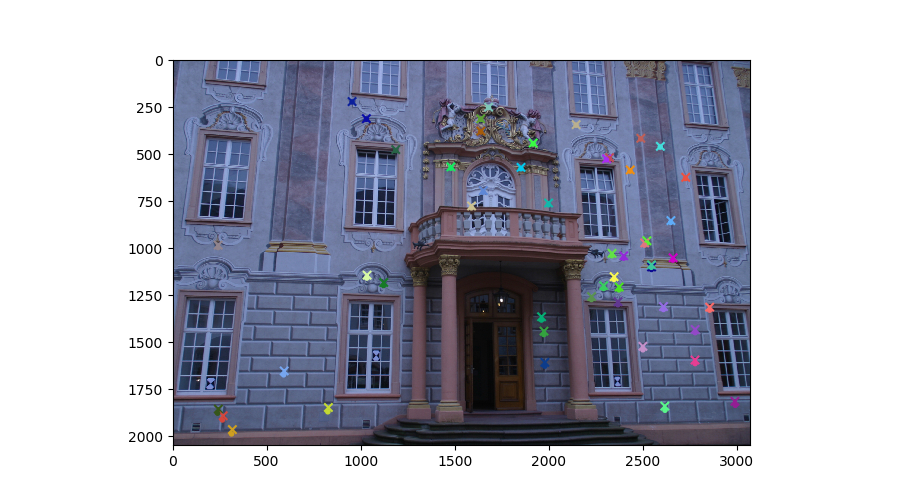

<IPython.core.display.Javascript object>


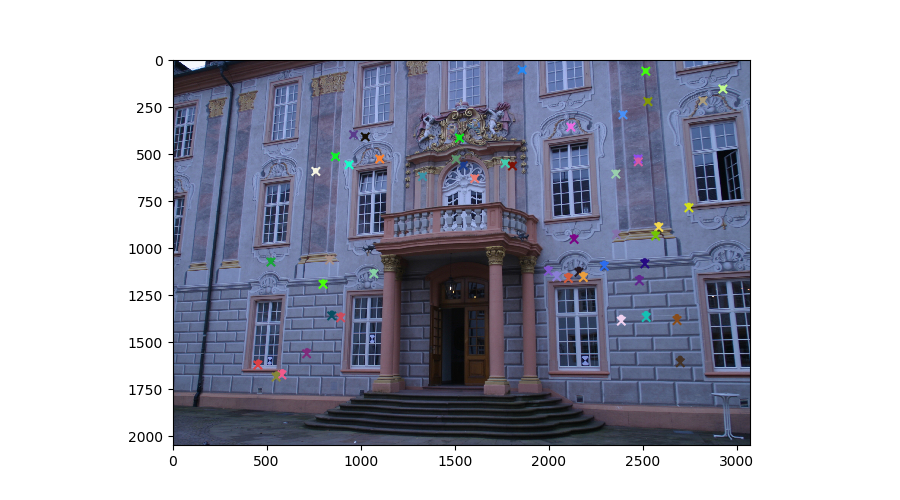

In [25]:
fig,ax=plt.subplots(figsize=(9,5))
ut.DrawCorrespondences(img1,img1pts[mask],img1ptsReproj,ax)

fig,ax=plt.subplots(figsize=(9,5))
ut.DrawCorrespondences(img2,img2pts[mask],img2ptsReproj,ax)

# 4. Perspective-n-Point Algorithm: New Camera Registration

## 4.0. Reading third image and 2D-3D Matching using SIFT

<IPython.core.display.Javascript object>


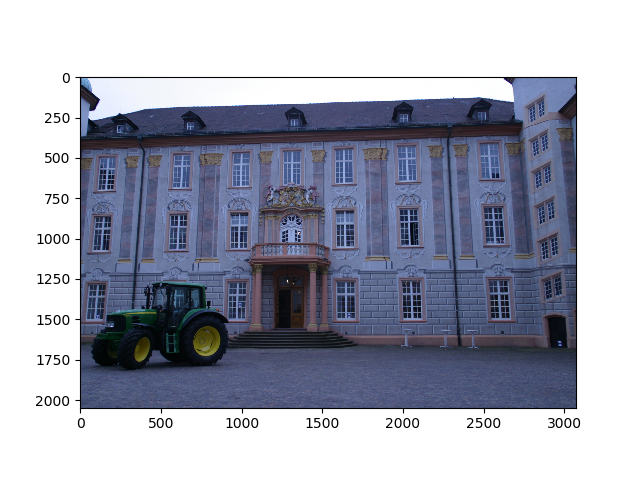

In [40]:
img3 = cv2.imread('../data/castle-P19/images/0006.jpg')
img3 = img3[:,:,::-1]
surfer=cv2.xfeatures2d.SURF_create()
kp3, desc3 = surfer.detectAndCompute(img3,None)

plt.figure()
plt.imshow(img3)

img3pts,pts3dpts = ut.Find2D3DMatches(desc1,img1idx,desc2,img2idx,desc3,kp3,mask,pts3d)

## 4.1. Perspective-n-Point (PnP) Algorithm

### 4.1.1. Least Squares Solution

In [28]:
from upenn_sfm_cache import LinearPnP
Rtest,ttest=LinearPnP(pts3dpts,img3pts,K)

### 4.1.2. RANSAC

In [44]:
retval,Rvec,tnew,mask3gt = cv2.solvePnPRansac(pts3dpts[:,np.newaxis],img3pts[:,np.newaxis],
                                            K,None,confidence=.99,flags=cv2.SOLVEPNP_DLS)
Rnew,_=cv2.Rodrigues(Rvec)

In [45]:
#Rnew,tnew,mask3=sfmnp.LinearPnPRansac(pts3dpts,img3pts,K,outlierThres=5.0,iters=2000)

In [51]:
tnew = tnew[:,0]

## 4.2. Visualizations

<IPython.core.display.Javascript object>


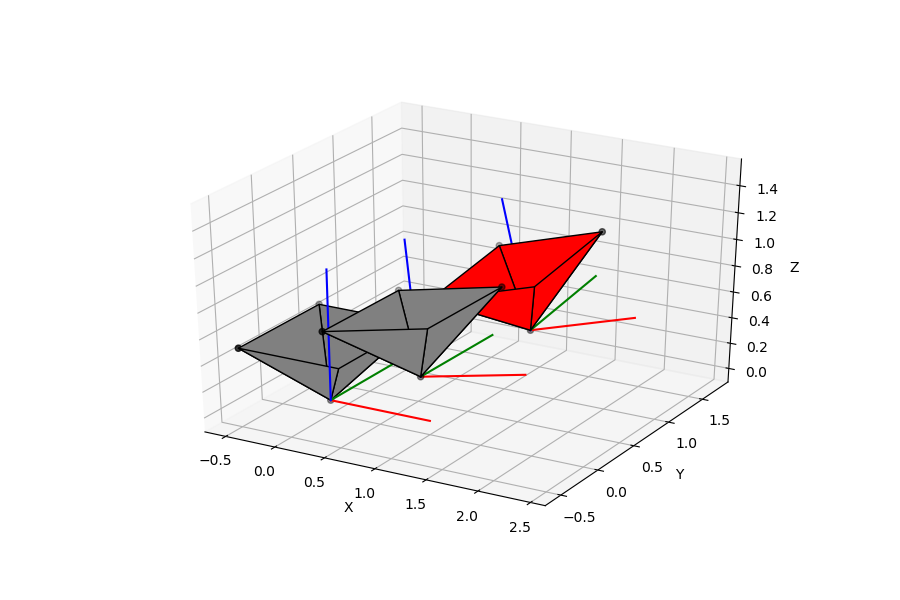

In [49]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ut.PlotCamera(np.eye(3,3),np.zeros((3,)),ax)
ut.PlotCamera(R,t[:,0],ax)
ut.PlotCamera(Rnew,tnew[:,0],ax,faceColor='red')

# 5. Re-triangulation

In [52]:
kpNew, descNew = kp3, desc3 

kpOld,descOld = kp1,desc1
ROld, tOld = np.eye(3), np.zeros((3,1))

accPts = []
for (ROld, tOld, kpOld, descOld) in [(np.eye(3),np.zeros((3,1)), kp1,desc1),(R,t,kp2,desc2)]: 
    
    #Matching between old view and newly registered view.. 
    print '[Info]: Feature Matching..'
    matcher = cv2.BFMatcher(crossCheck=True)
    matches = matcher.match(descOld, desc3)
    matches = sorted(matches, key = lambda x:x.distance)
    imgOldPts, imgNewPts, _, _ = ut.GetAlignedMatches(kpOld,descOld,kpNew,
                                                          descNew,matches)
    
    #Pruning the matches using fundamental matrix..
    print '[Info]: Pruning the Matches..'
    F,mask=cv2.findFundamentalMat(imgOldPts,imgNewPts,method=cv2.FM_RANSAC,param1=.1,param2=.99)
    mask = mask.flatten().astype(bool)
    imgOldPts=imgOldPts[mask]
    imgNewPts=imgNewPts[mask]
    
    #Triangulating new points
    print '[Info]: Triangulating..'
    newPts = sfmnp.GetTriangulatedPts(imgOldPts,imgNewPts, K, Rnew,tnew[:,np.newaxis],cv2.triangulatePoints,ROld,tOld)
    
    #Adding newly triangulated points to the collection
    accPts.append(newPts)

[Info]: Feature Matching..
[Info]: Pruning the Matches..
[Info]: Triangulating..
(3, 3) (3, 1) (3, 3) (3, 1)
[Info]: Feature Matching..
[Info]: Pruning the Matches..
[Info]: Triangulating..
(3, 3) (3, 1) (3, 3) (3, 1)


In [53]:
#Adding the original 2-view-sfm point cloud and saving the whole collection
accPts.append(pts3d)
ut.pts2ply(np.concatenate((accPts),axis=0),'castle_nview.ply')

# 6. Final Result 

<img src="fountain_dense.png">

# Chapter 4. Putting It Together: Part I

# Chapter 5. Bundle Adjustment

# Chapter 6. Putting It Together: Part II